In [32]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import datetime
import glob
import cv2

### Our data

##### Load data

In [3]:
dates = ['24032019', '17042019', '01052019']
labels = ['yafim', 'zeev', 'or', 'ron', 'sergey', 'aviya', 'elnatan']

In [4]:
x_data = []
y_data = []

In [5]:
for d in dates:
    for i, l in enumerate(labels):
        for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
            x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
            y_data.append(i)

100%|██████████| 3000/3000 [00:00<00:00, 8092.66it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:03<00:00, 8200.85it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:03<00:00, 8630.42it/s]
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:02<00:00, 8716.62it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 3000/3000 [00:00<00:00, 8396.37it/s]
0it [00:00, ?it/s]
100%|██████████| 3000/3000 [00:00<00:00, 8050.60it/s]


In [6]:
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

In [7]:
x_data.shape

(136000, 32, 32)

In [8]:
y_data

array([0, 0, 0, ..., 6, 6, 6])

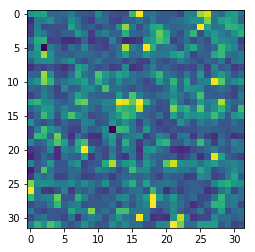

In [9]:
plt.imshow(x_data[0])
plt.show()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [11]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
x_train.shape

(108800, 32, 32)

In [33]:
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1217],
       [   1, 5007],
       [   2, 6636],
       [   3, 6658],
       [   4, 1153],
       [   5, 5896],
       [   6,  633]])

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
])

In [59]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 3591      
Total params: 528,391
Trainable params: 528,391
Non-trainable params: 0
_________________________________________________________________


In [69]:
def set_curr_time():
    dt = datetime.datetime.now()
    curr_dt = '{0}{1}{2}_{3}_{4}'.format(datetime.datetime.now().year, datetime.datetime.now().month,
                                       datetime.datetime.now().day, datetime.datetime.now().hour,
                                      datetime.datetime.now().minute)
    return curr_dt

In [57]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True, write_images=True)

In [58]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=50, callbacks=[tb_callback])

ValueError: You are passing a target array of shape (108800, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [62]:
model.evaluate(x_test, y_test)

27200/27200 [==============================] - 1s 45us/sample - loss: 2.1906 - acc: 0.0249


[2.1906236864538755, 0.02492647]

In [75]:
conf_list = [
    [32, 512, 0.2],
    [32, 256, 0.2],
    [32, 512, 0.1],
]

In [76]:
def custom_model(config):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(conf[0], conf[0])),
        tf.keras.layers.Dense(conf[1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(conf[2]),
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [77]:
for conf in conf_list:
    curr_dt = set_curr_time()
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/{0}_{1}'.format(conf, curr_dt),
                                                 histogram_freq=0, write_graph=True)
    model = custom_model(conf)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
              epochs=50, callbacks=[tb_callback])
    model.evaluate(x_test, y_test)
    model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))

Train on 108800 samples, validate on 27200 samples
Epoch 1/50
108800/108800 [==============================] - 4s 38us/sample - loss: 1.1719 - acc: 0.4724 - val_loss: 0.9985 - val_acc: 0.5406
Epoch 2/50
108800/108800 [==============================] - 4s 34us/sample - loss: 0.9623 - acc: 0.5655 - val_loss: 0.9232 - val_acc: 0.5921
Epoch 3/50
108800/108800 [==============================] - 4s 34us/sample - loss: 0.9195 - acc: 0.5900 - val_loss: 0.8833 - val_acc: 0.6138
Epoch 4/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.9030 - acc: 0.5976 - val_loss: 0.8786 - val_acc: 0.6143
Epoch 5/50
108800/108800 [==============================] - 4s 34us/sample - loss: 0.8800 - acc: 0.6123 - val_loss: 0.8536 - val_acc: 0.6253
Epoch 6/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.8679 - acc: 0.6176 - val_loss: 0.8583 - val_acc: 0.6181
Epoch 7/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.8555 - acc: 0.6227

108800/108800 [==============================] - 3s 24us/sample - loss: 0.8554 - acc: 0.6229 - val_loss: 0.8330 - val_acc: 0.6333
Epoch 8/50
108800/108800 [==============================] - 3s 24us/sample - loss: 0.8436 - acc: 0.6304 - val_loss: 0.8177 - val_acc: 0.6419
Epoch 9/50
108800/108800 [==============================] - 3s 24us/sample - loss: 0.8327 - acc: 0.6365 - val_loss: 0.8109 - val_acc: 0.6472
Epoch 10/50
108800/108800 [==============================] - 3s 24us/sample - loss: 0.8293 - acc: 0.6373 - val_loss: 0.8168 - val_acc: 0.6439
Epoch 11/50
108800/108800 [==============================] - 3s 24us/sample - loss: 0.8144 - acc: 0.6460 - val_loss: 0.8169 - val_acc: 0.6438
Epoch 12/50
108800/108800 [==============================] - 3s 23us/sample - loss: 0.8097 - acc: 0.6469 - val_loss: 0.7956 - val_acc: 0.6541
Epoch 13/50
108800/108800 [==============================] - 3s 24us/sample - loss: 0.8026 - acc: 0.6523 - val_loss: 0.7946 - val_acc: 0.6590
Epoch 14/50
108800/1

Epoch 14/50
108800/108800 [==============================] - 4s 37us/sample - loss: 0.7758 - acc: 0.6661 - val_loss: 0.7641 - val_acc: 0.6736
Epoch 15/50
108800/108800 [==============================] - 4s 37us/sample - loss: 0.7664 - acc: 0.6714 - val_loss: 0.7602 - val_acc: 0.6761
Epoch 16/50
108800/108800 [==============================] - 4s 37us/sample - loss: 0.7597 - acc: 0.6735 - val_loss: 0.7752 - val_acc: 0.6662
Epoch 17/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.7571 - acc: 0.6776 - val_loss: 0.7566 - val_acc: 0.6770
Epoch 18/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.7464 - acc: 0.6816 - val_loss: 0.7541 - val_acc: 0.6793
Epoch 19/50
108800/108800 [==============================] - 4s 38us/sample - loss: 0.7320 - acc: 0.6880 - val_loss: 0.7470 - val_acc: 0.6815
Epoch 20/50
108800/108800 [==============================] - 4s 37us/sample - loss: 0.7268 - acc: 0.6912 - val_loss: 0.7460 - val_acc: 0.6843
Epoch 

##### continues training

In [79]:
c_model = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')

In [80]:
c_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
              epochs=50, callbacks=[tb_callback])

Train on 108800 samples, validate on 27200 samples
Epoch 1/50
108800/108800 [==============================] - 4s 38us/sample - loss: 0.9533 - acc: 0.5728 - val_loss: 0.8804 - val_acc: 0.6037
Epoch 2/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.8633 - acc: 0.6125 - val_loss: 0.8448 - val_acc: 0.6270
Epoch 3/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.8428 - acc: 0.6237 - val_loss: 0.8382 - val_acc: 0.6372
Epoch 4/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.8259 - acc: 0.6343 - val_loss: 0.8250 - val_acc: 0.6406
Epoch 5/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.8123 - acc: 0.6428 - val_loss: 0.8121 - val_acc: 0.6474
Epoch 6/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.8077 - acc: 0.6449 - val_loss: 0.8207 - val_acc: 0.6395
Epoch 7/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.7951 - acc: 0.6513

In [81]:
c_model.evaluate(x_test, y_test)

27200/27200 [==============================] - 1s 46us/sample - loss: 0.7825 - acc: 0.6661


[0.7825135770615409, 0.66610295]

In [84]:
for model_path in glob.glob('../models/*.h5'):
    print(model_path)
    best_loaded = tf.keras.models.load_model(model_path)
    best_loaded.evaluate(x_test, y_test)

../models/[32, 512, 0.2]_201953_12_51.h5
27200/27200 [==============================] - 1s 54us/sample - loss: 0.7060 - acc: 0.7012
../models/[32, 256, 0.2]_201953_12_54.h5
27200/27200 [==============================] - 1s 44us/sample - loss: 0.7264 - acc: 0.6867
../models/[32, 512, 0.1]_201953_12_56.h5
27200/27200 [==============================] - 2s 59us/sample - loss: 0.6649 - acc: 0.7292
../models/[32, 512, 0.2]_201953_12_46.h5
27200/27200 [==============================] - 2s 61us/sample - loss: 0.7218 - acc: 0.6947
